In [103]:
from spacy.lang.en import English
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy import displacy
from IPython.display import clear_output
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


import nltk
#nltk.download('wordnet')

In [58]:
news = pd.read_csv('data/news.tsv', header=None, sep='\t')
news.columns=['News ID', "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities "]

In [59]:
df_news = copy.deepcopy(news)

df_news.head()

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


Now that we have the news data frame set, we will look to tokenize the text for processing later.

In [60]:
nlp = English()

text_list = []

for t in df_news['Title'].values:
    doc = nlp(t)
    tokens = []
    for w in doc:
        tokens.append(w.text)
    text_list.append(tokens)

df_news['Title'] = text_list

In [61]:
df_news['Title'].head()

0    [The, Brands, Queen, Elizabeth, ,, Prince, Cha...
1                 [50, Worst, Habits, For, Belly, Fat]
2    [The, Cost, of, Trump, 's, Aid, Freeze, in, th...
3    [I, Was, An, NBA, Wife, ., Here, 's, How, It, ...
4    [How, to, Get, Rid, of, Skin, Tags, ,, Accordi...
Name: Title, dtype: object

In [62]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [63]:
new_text = []
for t in df_news['Title'].values:
    words = []
    for j in t:
        if j.lower() in stopwords:
            continue
        else:
            words.append(j)
    new_text.append(words)
    
df_news['Title'] = new_text

In [64]:
df_news['Title'].head()

0    [Brands, Queen, Elizabeth, ,, Prince, Charles,...
1                      [50, Worst, Habits, Belly, Fat]
2    [Cost, Trump, Aid, Freeze, Trenches, Ukraine, ...
3          [NBA, Wife, ., Affected, Mental, Health, .]
4       [Rid, Skin, Tags, ,, According, Dermatologist]
Name: Title, dtype: object

We now have the titles without common stop words and tokenized by words. We will now lemmatize the lists, combining words with similar roots.

In [65]:
lemmatizer = WordNetLemmatizer()

title = []

for row in df_news['Title']:
    words = []
    for word in row:
        w = lemmatizer.lemmatize(word, pos='a')
        w = lemmatizer.lemmatize(w)
        words.append(w)
    title.append(words)

df_news['Title'] = title

In [66]:
df_news['Title'].head()

0    [Brands, Queen, Elizabeth, ,, Prince, Charles,...
1                      [50, Worst, Habits, Belly, Fat]
2    [Cost, Trump, Aid, Freeze, Trenches, Ukraine, ...
3          [NBA, Wife, ., Affected, Mental, Health, .]
4       [Rid, Skin, Tags, ,, According, Dermatologist]
Name: Title, dtype: object

In [72]:
import en_core_web_sm

In [76]:
nlp = en_core_web_sm.load()
n = nlp(news['Title'][40000])
entities = [(i, i.label_, i.label) for i in n.ents]
entities

[(Ford, 'ORG', 383),
 ($1 billion, 'MONEY', 394),
 (Avon Lake, 'LOC', 385),
 (Brook Park, 'LOC', 385),
 (Greater Cleveland, 'GPE', 384)]

In [78]:
displacy.render(n, style = "ent",jupyter = True)

In [79]:
displacy.render(n, style = "dep",jupyter = True)

We will now look to create sentences for classification.

In [80]:
sentence = []

for row in df_news['Title']:
    s = ''
    for word in row:
        s += word.lower()+' '
    sentence.append(s)
    
df_news['Title'] = sentence

In [81]:
df_news['Title'].head()

0    brands queen elizabeth , prince charles , prin...
1                           50 worst habits belly fat 
2          cost trump aid freeze trenches ukraine war 
3                 nba wife . affected mental health . 
4             rid skin tags , according dermatologist 
Name: Title, dtype: object

In [82]:
X = df_news['Title'].values
y = df_news['Category'].values

In [84]:
classifier = RandomForestClassifier()

tfidf_vector = TfidfVectorizer()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [93]:
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [87]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [88]:
prediction = pipe.predict(X_test)

In [90]:
# Model Accuracy
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, prediction))
print("Random Forest Precision:",metrics.precision_score(y_test, prediction,average='weighted'))
print("Random Forest Recall:",metrics.recall_score(y_test, prediction,average='weighted'))

Random Forest Accuracy: 0.6716282092947676
Random Forest Precision: 0.6633408910508324
Random Forest Recall: 0.6716282092947676


C:\Users\david\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
temp = pd.DataFrame(y_test)

In [123]:
categories = temp[0].unique()

In [125]:
categories.sort()

categories

array(['autos', 'entertainment', 'finance', 'foodanddrink', 'health',
       'kids', 'lifestyle', 'middleeast', 'movies', 'music', 'news',
       'sports', 'travel', 'tv', 'video', 'weather'], dtype=object)

In [118]:
pl = confusion_matrix(y_test, prediction)

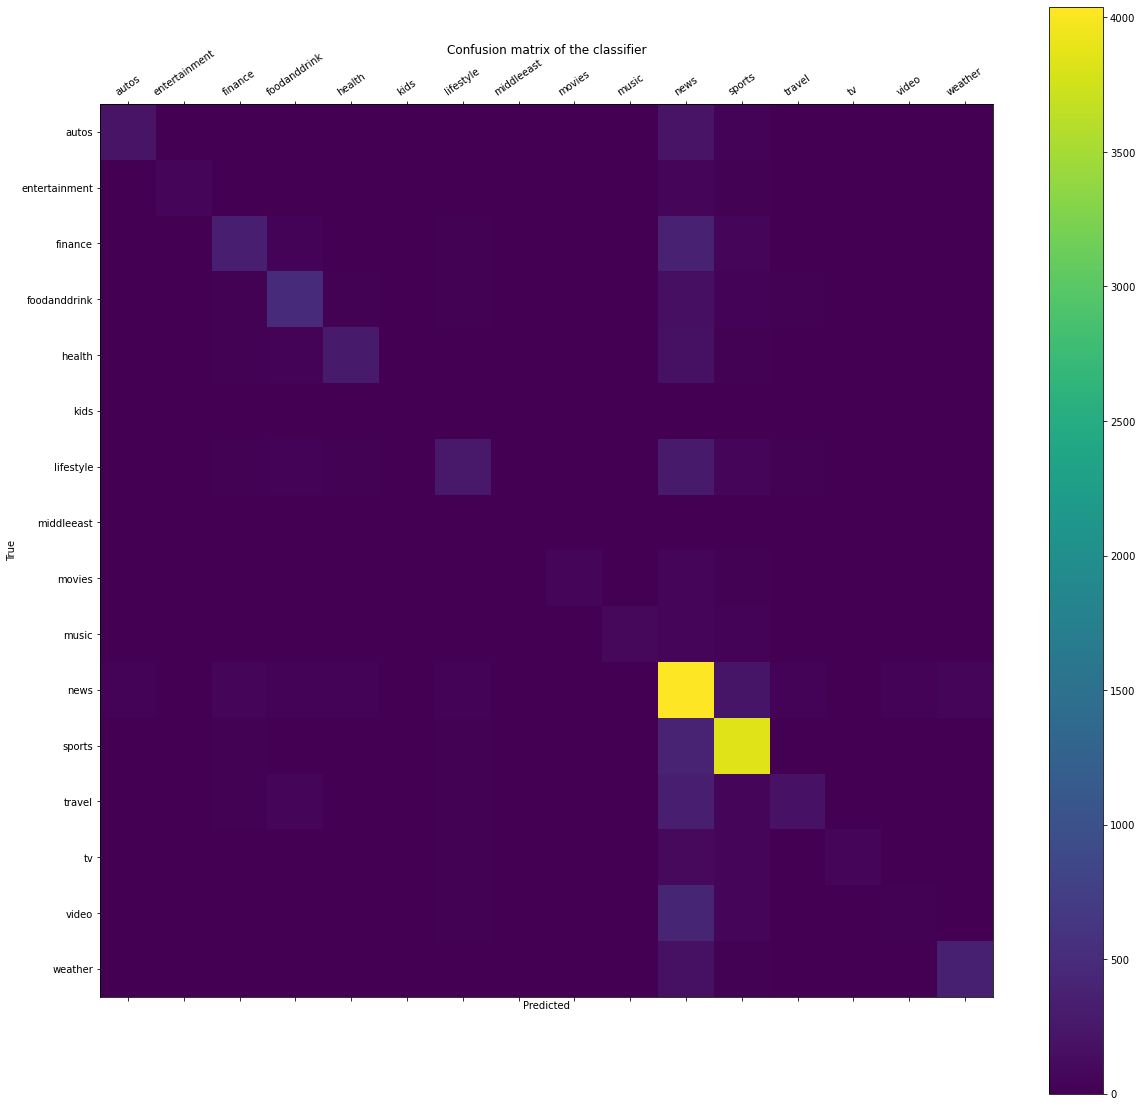

In [135]:
labels = categories



fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels([''] + labels, rotation=35)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [114]:
temp.groupby(0)[0].count()

0
autos             489
entertainment     163
finance           895
foodanddrink      776
health            593
kids                8
lifestyle         759
middleeast          1
movies            172
music             246
news             4681
sports           4346
travel            752
tv                288
video             614
weather           602
Name: 0, dtype: int64

In [140]:
y_test_df[y_test_df['Category']=='news'].head()

,Category
0,news
5,news
6,news
7,news
9,news
